# Convolutional Neural Networks for Sentence Classification

_This notebook demonstrates the implementation of Convolutional Neural Networks for Sentence Classification proposed by [Kim, 2014](https://arxiv.org/pdf/1408.5882.pdf)._


Traditionally, Convolutional Neural Networks (CNNs) were invented for computed vision and achieved state-of-the-art performance in computer vision and speech recognition. CNNs act like feature extractors where they scan different regions of the image using the kernel and output of each layer is passed to the next CNN layer. The lower layers in CNNs are useful at detecting low-level features such as edges whereas the higher layers in CNNs are useful at detecting facial features such as eyes, nose, ear, etc.

The above paper proposed by [Kim, 2014](https://arxiv.org/pdf/1408.5882.pdf) was one of the earliest work demonstrating the applications of CNNs in NLP tasks, specifically text classification. In this case, CNN is used as a feature extractor which encodes semantic features of text and then these features are fed into classifier.

RNNs extract the prefix sequence features which might not be always helpful as preserving complete context is very difficult for longer sequences and we may get wrong prediction. CNNs help us to extract subsequence features which are beneficial for classification tasks as the dominant features context would be preserved.

We will build a CNN based sentiment classifier for IMDB movie reviews.


In [1]:
%%capture
# download the spacy language models for english
!python -m spacy download en --quiet

In [2]:
%%capture
!pip install torchtext --upgrade

In [3]:
%%capture
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip crawl-300d-2M.vec.zip
!rm -rf crawl-300d-2M.vec.zip

## Imports


In [4]:
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy
import torchtext
import torchtext.vocab as vocab
from torchtext.legacy.datasets import IMDB
from torchtext.legacy.data import Field, LabelField, BucketIterator

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [5]:
# for reproducibility
# refer https://pytorch.org/docs/stable/notes/randomness.html
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing and Loading


In [32]:
# create field objects for text and label
review = Field(tokenize='spacy', batch_first=True)
sentiment = LabelField(batch_first=True)

# load the imdb dataset
train_data, test_data = IMDB.splits(text_field=review, label_field=sentiment)
train_data, valid_data = train_data.split()

In [33]:
# load the pretrained fasttext embeddings and build the vocabulary
en_fast_embed = vocab.Vectors(name='crawl-300d-2M.vec', cache='.', unk_init = torch.Tensor.normal_)
review.build_vocab(train_data, max_size=25000, vectors=en_fast_embed)
sentiment.build_vocab(train_data)

del en_fast_embed

In [34]:
print(f'# of training examples: {len(train_data.examples)}')
print(f'# of validation examples: {len(valid_data.examples)}')
print(f'# of testing examples: {len(test_data.examples)}')

print(train_data[0].__dict__.keys())
print(train_data[0].__dict__.values())

# of training examples: 17500
# of validation examples: 7500
# of testing examples: 25000
dict_keys(['text', 'label'])
dict_values([['The', 'fact', 'that', 'someone', 'actually', 'spent', 'money', 'on', 'such', 'a', 'bad', 'script', ',', 'is', 'beyond', 'me', '.', 'This', 'really', 'must', 'be', 'one', 'of', 'the', 'worst', 'films', ',', 'in', 'addition', 'to', '"', 'Haunted', 'Highway', '"', 'I', 'have', 'ever', 'seen', '.', 'BAD', 'actors', ',', 'and', 'a', 'really', 'bad', 'story', '.', 'There', "'s", 'no', 'normal', 'reactions', 'to', 'any', 'event', 'in', 'this', 'film', ',', 'and', 'even', 'though', 'it', "'s", 'Halloween', ',', 'normal', 'people', 'would', 'have', 'bigger', 'reactions', 'when', 'they', "'re", 'witnessing', 'their', 'father', 'being', 'killed', ',', 'not', 'to', 'mention', 'gutted', ',', 'people', 'with', 'tape', 'covering', 'their', 'airways', ',', 'not', 'being', 'able', 'to', 'breathe', '(', 'in', 'a', 'room', 'with', 'at', 'least', '50', 'people', 'I', 'might

In [35]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device
)

In [36]:
# sanity check to see if data loader is working
x = next(iter(train_iterator))

print({'text': x.text.shape, 'label': x.label.shape})

{'text': torch.Size([64, 1150]), 'label': torch.Size([64])}


## Model Architecture


![cnn_architecture](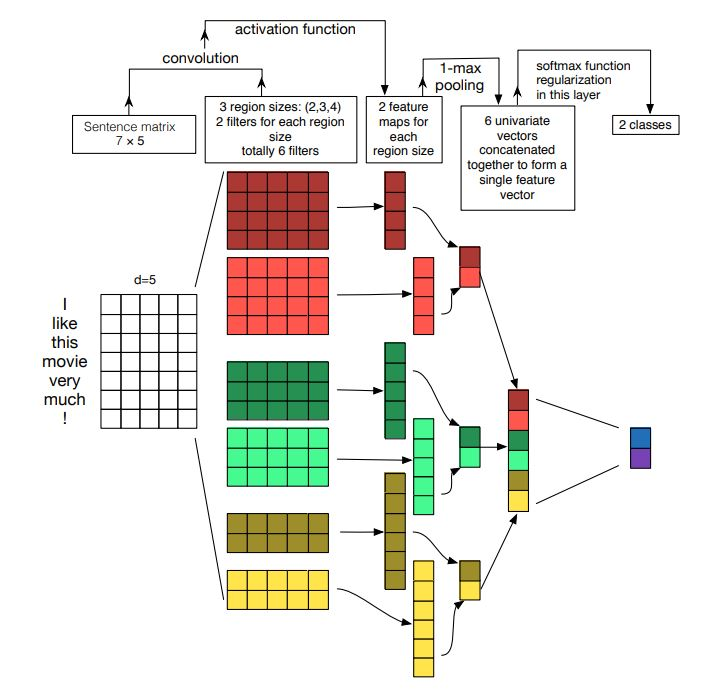 "CNN architecture for sentence classification")

(source: https://arxiv.org/pdf/1510.03820.pdf)


CNN based text classifier reads the input sequence and generates a feature representation for the subsequences which are used for classification.

For the implementation in this notebook, we first apply the embedding layer on the input sequence $x$ to obtain the embedded representation $x_{emb}$. Next, we apply 1D convolutions of different filter sizes to obtain feature map $x_{conv_i}$ corresponding to each filter $i$. Further, we apply ReLU activation and max pooling over time to reduce each feature map to a single scalar $x_{pool_i}$ and concatenate all these scalar values $x_concat$. Finally, linear transformation is applied over the concatenated representation using the weight matrix $W$ to compute logits. Either sigmoid or softmax is applied to these computed logits depending on the classification problem i.e. binary or multi-class.

$$
x_{emb} = f_{embedding}(x) \\
x_{conv_i} = \text{conv1D}(x_{emb}) \\
x_{pool_i} = \text{maxpool}(relu(x_{conv_i})) \\
x_{concat} = [x_{pool_i}; \dots; x_{pool_j}] \\
\text{logits} = \text{dropout}(Wx_{concat})
$$


In [37]:
class CNNTextClassifier(nn.Module):
    """ Simple 1D Convolutional Neural Network for Sentence Classification.
    """

    def __init__(self, vocab_size, n_classes, embed_size, filter_sizes, n_filters, pad_idx, dropout_rate=0.5):
        super(CNNTextClassifier, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.filter_sizes = filter_sizes
        self.n_filters = n_filters
        self.n_classes = n_classes
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.conv_list =  nn.ModuleList([
            nn.Conv1d(in_channels=embed_size, out_channels=n_filters, kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, n_classes)
        self.dropout = nn.Dropout(dropout_rate)

    
    def load_pretrained_embeddings(self, embeddings, fine_tune=False):
        self.embedding.weight = nn.Parameter(embeddings)
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
    

    def _conv_block(self, x, conv_layer):
        """ x: (batch_size, embed_size, seq_len)
        """
        x_conv = F.relu(conv_layer(x))  # (batch_size, n_filters, seq_len - filter_sizes[i] + 1)
        x_pool = F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]).squeeze(2)  # (batch_size, n_filters)
        return x_pool


    def forward(self, x):
        """ x: (batch_size, seq_len)
        """
        embed = self.embedding(x)  # (batch_size, seq_len, embed_size)
        embed = embed.permute(0, 2, 1)  # (batch_size, embed_size, seq_len)

        conv_stack = [
            self._conv_block(embed, conv) for conv in self.conv_list
        ]

        pooled_values = torch.cat(conv_stack, dim=1)  # (batch_size, sum(num_filters))      

        logits = self.fc(self.dropout(pooled_values))  # (batch_size, num_classes)

        return logits

## Helper Utilities


In [38]:
def model_summary(model):
    print(model)
    print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'# of non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}')

In [39]:
def accuracy(preds, y):
    top_preds = preds.argmax(dim=1, keepdim=True)
    correct = (top_preds == y.view_as(top_preds)).sum()
    acc = correct / len(y)
    return acc

## Training


In [46]:
def train_fn(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    for idx, batch in enumerate(tk0):
        
        # forward pass
        optimizer.zero_grad()
        logits = model(batch.text)  # (batch_size)
        
        # calcalute loss
        loss = criterion(logits, batch.label)
        
        # calculate accuracy
        acc = accuracy(logits, batch.label)
        
        # backward pass
        loss.backward()
        
        # update model parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        tk0.update(0)
    
    tk0.close()
        
    return epoch_acc / len(iterator), epoch_loss / len(iterator)

In [47]:
def eval_fn(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    with torch.no_grad():
        for idx, batch in enumerate(tk0):
            
            # forward pass
            logits = model(batch.text)  # (batch_size)
            
            # calcalute loss
            loss = criterion(logits, batch.label)
            
            # calculate accuracy
            acc = accuracy(logits, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            tk0.update(0)
    
    tk0.close()
        
    return epoch_acc / len(iterator), epoch_loss / len(iterator)

In [48]:
# hyperparameters
VOCAB_SIZE = len(review.vocab)
EMBED_SIZE = review.vocab.vectors.shape[1]
FILTER_SIZES = [3, 4, 5]
N_FILTERS = 100
N_CLASSES = len(sentiment.vocab)
DROPOUT_RATE = 0.5
PAD_IDX = review.vocab.stoi[review.pad_token]
N_EPOCHS = 20

In [54]:
model = CNNTextClassifier(VOCAB_SIZE, N_CLASSES, EMBED_SIZE, FILTER_SIZES, N_FILTERS, PAD_IDX, DROPOUT_RATE)
# load the pre-trained GloVe embedding
model.load_pretrained_embeddings(review.vocab.vectors, fine_tune=True)
model = model.to(device)

model_summary(model)

CNNTextClassifier(
  (embedding): Embedding(25002, 300, padding_idx=1)
  (conv_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
# of trainable params: 7,861,502
# of non-trainable params: 0


In [55]:
optimizer = optim.Adadelta(model.parameters(), lr=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=0, threshold=0.001, mode='max'
)

In [56]:
criterion = nn.CrossEntropyLoss()

In [ ]:
best_acc = 0
es_patience = 3
patience = 0
model_path = 'model.pth'


for epoch in range(0, N_EPOCHS + 1):
    # one epoch training
    train_acc, train_loss = train_fn(model, train_iterator, optimizer, criterion)
    
    # one epoch validation
    valid_acc, valid_loss = eval_fn(model, valid_iterator, criterion)
    
    print(f'Epoch: {epoch}, Train Accuracy: {train_acc * 100:.2f}%, Train loss: {train_loss:.4f}, Valid Accuracy: {valid_acc * 100:.2f}%,, Valid Loss: {valid_loss:.4f}')
    
    scheduler.step(valid_acc)

    is_best = valid_acc > best_acc
    if is_best:
        print(f'Best accuracy improved ({best_acc * 100:.2f}% -> {valid_acc * 100:.2f}%). Saving Model!')
        best_acc = valid_acc
        patience = 0
        torch.save(model.state_dict(), model_path)
    else:
        patience += 1
        print(f'Early stopping counter: {patience} out of {es_patience}')
        if patience == es_patience:
            print(f'Early stopping! Best accuracy: {best_acc * 100:.2f}%')
            break

In [58]:
# evaluate the model on test data
model.load_state_dict(torch.load(model_path, map_location=device))

print('Evaluating the model on test data ...')
test_acc, test_loss = eval_fn(model, test_iterator, criterion)
print(f'Test Accuracy: {test_acc * 100:.2f}%, Test loss: {test_loss:.4f}')

Evaluating the model on test data ...



Test Accuracy: 86.63%, Test loss: 0.3117


## Inferences


In [59]:
nlp = spacy.load('en')

def predict(model, text, min_len=5):
    model.eval()

    tokens = [token.text for token in nlp.tokenizer(text)]

    if len(tokens) < min_len:
        tokens += [review.pad_token] * (min_len - len(tokens))
    
    token_ids = [review.vocab.stoi.get(token, review.unk_token) for token in tokens]

    token_ids = torch.tensor(token_ids, dtype=torch.long).to(device)  # (seq_len)
    token_ids = token_ids.unsqueeze(0)  # (1, seq_len)

    logits = model(token_ids)

    pred_probs = F.softmax(logits, dim=1).squeeze(0)

    return pred_probs

In [67]:
sample_text = 'The movie was great!'
print(sample_text)

pred_probs = predict(model, sample_text)
print(f'positive: {pred_probs[0] * 100:.2f}%, negative: {(pred_probs[1]) * 100:.2f}%')

The movie was great!
positive: 73.38%, negative: 26.62%


In [68]:
sample_text = 'The movie was okay.'
print(sample_text)

pred_probs = predict(model, sample_text)
print(f'positive: {pred_probs[0] * 100:.2f}%, negative: {(pred_probs[1]) * 100:.2f}%')

The movie was okay.
positive: 34.23%, negative: 65.77%


In [69]:
sample_text = 'The movie was terrible...'
print(sample_text)

pred_probs = predict(model, sample_text)
print(f'positive: {pred_probs[0] * 100:.2f}%, negative: {(pred_probs[1]) * 100:.2f}%')

The movie was terrible...
positive: 9.10%, negative: 90.90%


## References

1. [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf)
2. [A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1510.03820.pdf)
3. [Official Theano Implementation by Yoon Kim](https://github.com/yoonkim/CNN_sentence)
4. [PyTorch Sentiment Analysis by Ben Trevet](https://github.com/bentrevett/pytorch-sentiment-analysis)
